<h1 align="center"> Ordered sets for data analysis

## <font color="green"> Big home assignment </font>: LazyFCA

### Work has been done by: Ryabykin Aleksey
---

<a name = 'content'></a>
<h1 align="center">Table of Contents

#### [Part 1. Car dataset](#step1)
 * ##### [Data preparation (binarization)](#step1.1)
 * ##### [Algorithm scoring](#step1.2)
 * ##### [Algorithm improvements and comparisons](#step1.3)
 <!-- * ##### [Getting rid off the binarizations](#step1.4) -->

#### [Part 2. Applying to the dataset Mushrooms](#step2)
 * ##### [Initial algorithm](#step2.1)
 * ##### [Algorithm with proposed improvements](#step2.2)


#### [Part 3. Applying to the Congressional Voting Records Data Set](#step3)
 * ##### [Initial algorithm](#step3.1)
 * ##### [Algorithm with proposed improvements](#step3.2)

 #### [Part 4. Comparison with other rule-based models](#step4)

 #### [Part 5. Inferences](#step5)

In [37]:
from IPython.display import display, HTML, Markdown
display(HTML("<style>.container { width:90% !important; }</style>"))
import os
import lazy_pipeline as lpipe
import warnings
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm

DATA_PATH = "./data/"
CARS_DATA_PATH = os.path.join(DATA_PATH, "cars/car.data")
MUSHROOM_DATA_PATH = os.path.join(DATA_PATH, "mushroom/agaricus-lepiota.data")
CONGRESS_VOTING_DATA_PATH = os.path.join(DATA_PATH, "congress_voting/house-votes-84.data")

In [3]:
CARS_COLUMNS_NAMES = [
    "buying", "maint", "doors", "persons",
    "lug_boot", "safety", "target"
]

MUSHROOM_COLUMNS_NAMES = [
    "target", "cap-shape", "cap-surface", "cap-color",
    "bruises?", "odor", "gill-attachment", 
    "gill-spacing", "gill-size", "gill-color",
    "stalk-shape", "stalk-root", "stalk-surface-above-ring",
    "stalk-surface-below-ring", "stalk-color-above-ring",
    "stalk-color-below-ring", "veil-type", "veil-color",
    "ring-number", "ring-type", "spore-print-color",
    "population", "habitat"
]

CONGRESS_VOTING_COLUMNS_NAMES = [
    'target', 'handicapped-infants', 
    'water-project-cost-sharing', 'adoption-of-the-budget-resolution',
    'physician-fee-freeze', 'el-salvador-aid', 
    'religious-groups-in-schools', 'anti-satellite-test-ban',
    'aid-to-nicaraguan-contras', 'mx-missile', 'immigration', 
    'synfuels-corporation-cutback', 'education-spending', 
    'superfund-right-to-sue', 'crime', 'duty-free-exports',
    'export-administration-act-south-africa'
]

<a name="step1"> </a>

## Car dataset

[To the ToC](#content)


<a name="step1.1"> </a>

## Data preparation

In [4]:
data = pd.read_csv(CARS_DATA_PATH, names=CARS_COLUMNS_NAMES, index_col=None)
print(data.shape)
data.sample(3)

(1728, 7)


,buying,maint,doors,persons,lug_boot,safety,target
152,vhigh,high,3,4,big,high,unacc
31,vhigh,vhigh,3,2,med,med,unacc
1158,med,med,4,more,big,low,unacc


In [5]:
data["target"].value_counts()

unacc    1210
acc       384
good       69
vgood      65
Name: target, dtype: int64

In [6]:
data = data[(data['target'] != 'good') & (data['target'] != 'vgood')]

In [7]:
data["target"].value_counts()

unacc    1210
acc       384
Name: target, dtype: int64

In [8]:
data.loc[data['target'] == 'unacc', "target"] = False
data.loc[data['target'] == 'acc', "target"] = True

In [9]:
data["target"].value_counts()

False    1210
True      384
Name: target, dtype: int64

Target variable is not well balanced. That is why we should to choose f1-score to make more confident inferences about models performance.

Let's binarize the data

In [10]:
data.sample(3)

,buying,maint,doors,persons,lug_boot,safety,target
246,vhigh,med,3,2,med,low,False
1004,med,high,3,2,med,high,False
1446,low,high,3,4,big,low,False


In [11]:
X = lpipe.binarize_X(data.drop("target", axis=1))
y = data["target"]

In [12]:
X.head()

,buying: high,buying: low,buying: med,buying: vhigh,maint: high,maint: low,maint: med,maint: vhigh,doors: 2,doors: 3,...,doors: 5more,persons: 2,persons: 4,persons: more,lug_boot: big,lug_boot: med,lug_boot: small,safety: high,safety: low,safety: med
0,False,False,False,True,False,False,False,True,True,False,...,False,True,False,False,False,False,True,False,True,False
1,False,False,False,True,False,False,False,True,True,False,...,False,True,False,False,False,False,True,False,False,True
2,False,False,False,True,False,False,False,True,True,False,...,False,True,False,False,False,False,True,True,False,False
3,False,False,False,True,False,False,False,True,True,False,...,False,True,False,False,False,True,False,False,True,False
4,False,False,False,True,False,False,False,True,True,False,...,False,True,False,False,False,True,False,False,False,True


In [13]:
X = X.sample(frac=1, random_state=42)  # Shuffle X
y = y[X.index]  # Order y to follow the order of rows from X

In [14]:
X_bin = [set(X.columns[x]) for idx, x in X.iterrows()]
X_bin[0]

{'buying: med',
 'doors: 3',
 'lug_boot: big',
 'maint: vhigh',
 'persons: more',
 'safety: high'}

In [15]:
y = y.values.tolist()

In [16]:
n_train = int(len(X)*0.1)
n_test = len(X) - n_train
y_test = y[n_train:]
n_train, n_test

(159, 1435)

<a name="step1.2"> </a>

### Algorithm scoring

In [17]:
%%time
gen = lpipe.predict_array(X_bin, y, n_train, use_tqdm=True)
y_preds, t_preds = lpipe.apply_stopwatch(gen)

Predicting step by step: 100%|██████████| 1594/1594 [00:37<00:00, 38.52it/s]

CPU times: total: 8.48 s
Wall time: 37.3 s


In [18]:
%%time
gen = list(lpipe.predict_array(X_bin, y, n_train, use_tqdm=True, update_train=False))
y_preds_fixedtrain, t_preds_fixedtrain = lpipe.apply_stopwatch(gen)

Predicting step by step: 100%|██████████| 1594/1594 [00:00<00:00, 1714.29it/s]

CPU times: total: 234 ms
Wall time: 839 ms


In [19]:
from sklearn.metrics import accuracy_score, f1_score

score_vals = {}
for score_f in [accuracy_score, f1_score]:
    score_name = score_f.__name__
    preds = y_preds
    score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]
    
    score_name = score_f.__name__ + '_fixedtrain'
    preds = y_preds_fixedtrain
    score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]

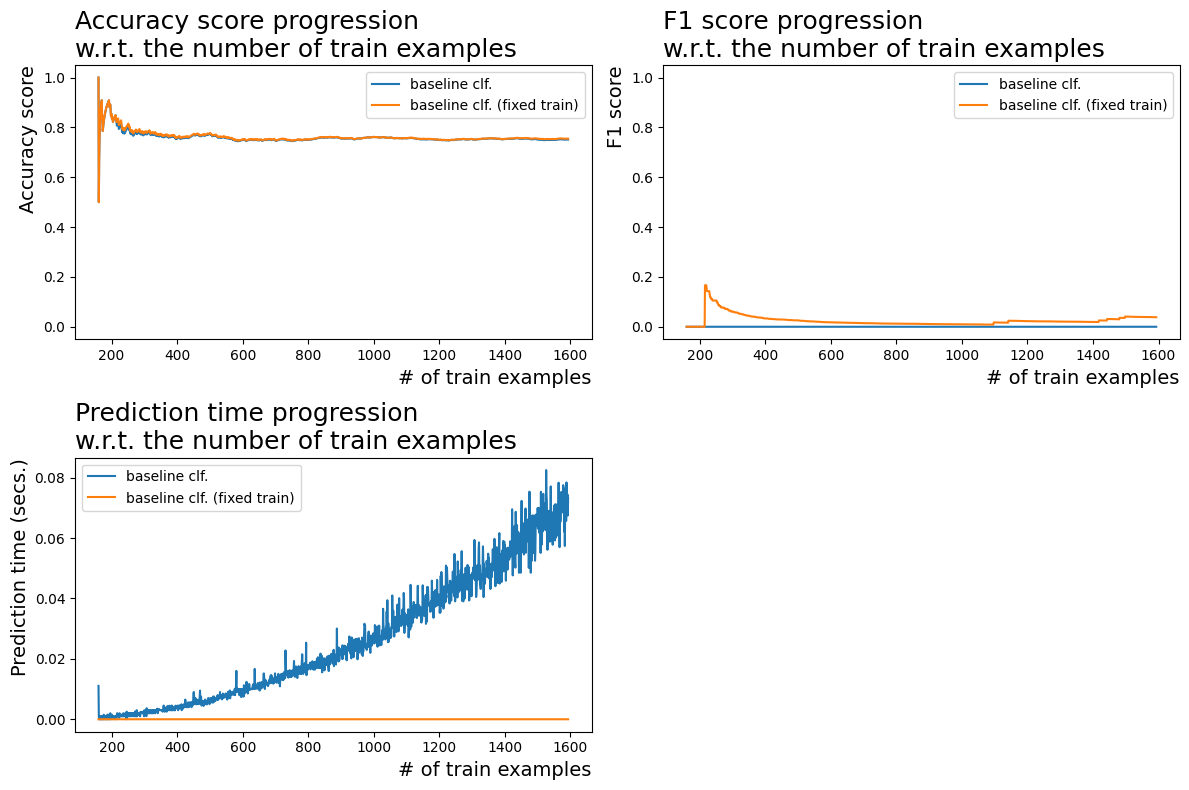

In [20]:
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = (1,1,1,1)  # Replace default "transparent" background of the figure with the "white" one


fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# First two plots are for prediction quality comparison
for ax, t in zip(axs[0],['accuracy_score', 'f1_score']):
    ax.set_ylim(0-0.05, 1+0.05)
    ax.plot(range(n_train+1, len(X)), score_vals[t], label='baseline clf.')
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_fixedtrain'], label='baseline clf. (fixed train)')
    
# The third plot is for prediction speed comparison
axs[1,0].plot(range(n_train, len(X)), t_preds, label='baseline clf.')
axs[1,0].plot(range(n_train, len(X)), t_preds_fixedtrain, label='baseline clf. (fixed train)')

# Add labels and titles to the plots
for (ax, t_verb, dim) in zip(axs.flatten(), ['Accuracy score', 'F1 score', 'Prediction time'], ['','','(secs.)']):
    ax.set_title('\n'.join([f"{t_verb} progression", "w.r.t. the number of train examples"]), loc='left', size=18)
    ax.set_xlabel('# of train examples', loc='right', size=14)
    ax.set_ylabel(f"{t_verb} {dim}".strip(), loc='top', size=14)
    ax.legend()
    
# Drop the predefined fourth plot since we do not use it
axs[1,1].set_axis_off()    

# Some postprocessing of plots
plt.tight_layout()
plt.subplots_adjust()

plt.savefig('Classifier_comparison_initial_algo_car.png')
plt.show()

<a name="step1.3"> </a>

### Algorithm improvements and comparisons

In [81]:
import lazy_improved_pipeline as lpipe_improved


In [22]:
%%time
gen = lpipe_improved.predict_array(X, y, n_train, use_tqdm=True)
y_preds, t_preds = lpipe.apply_stopwatch(gen)

Predicting step by step: 100%|██████████| 1594/1594 [00:08<00:00, 160.05it/s]

CPU times: total: 7.17 s
Wall time: 8.97 s


In [23]:
%%time
gen = list(lpipe_improved.predict_array(X, y, n_train, use_tqdm=True, update_train=False))
y_preds_fixedtrain, t_preds_fixedtrain = lpipe.apply_stopwatch(gen)

Predicting step by step: 100%|██████████| 1594/1594 [00:00<00:00, 2552.03it/s]

CPU times: total: 344 ms
Wall time: 563 ms


In [24]:
from sklearn.metrics import accuracy_score, f1_score

score_vals = {}
for score_f in [accuracy_score, f1_score]:
    score_name = score_f.__name__
    preds = y_preds
    score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]
    
    score_name = score_f.__name__ + '_fixedtrain'
    preds = y_preds_fixedtrain
    score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]

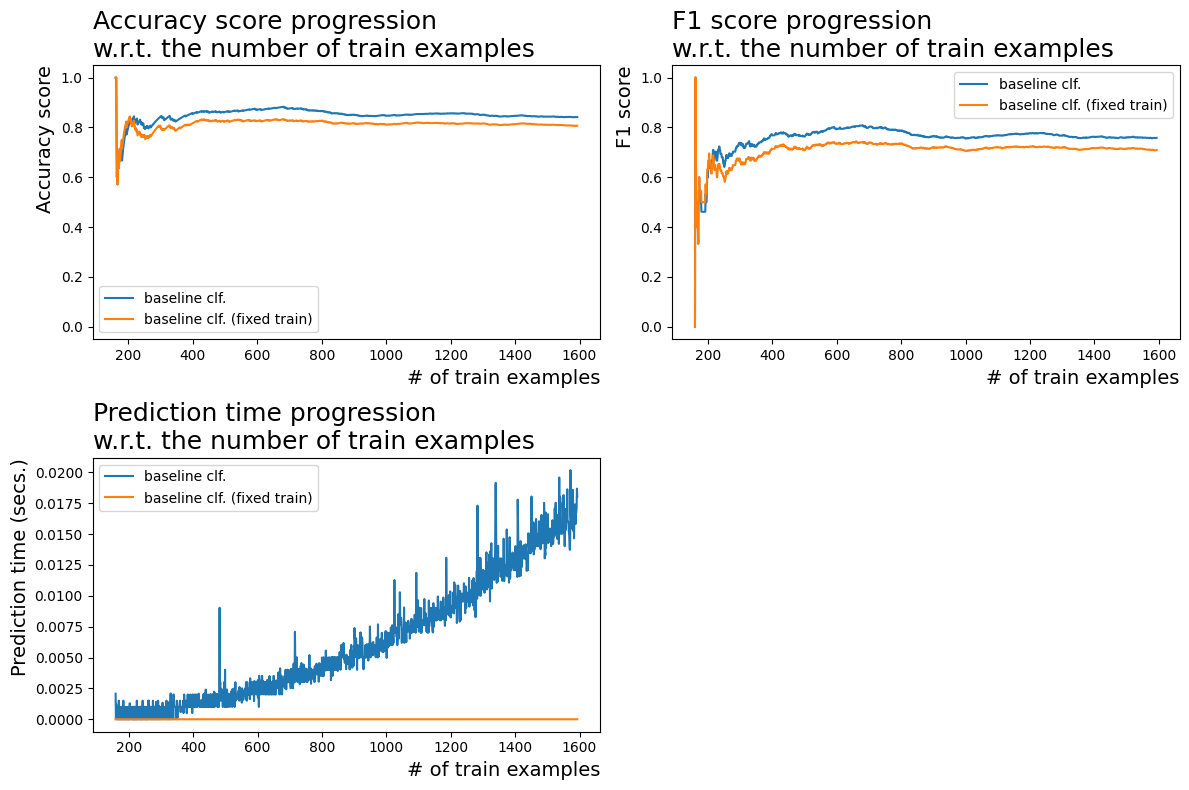

In [25]:
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = (1,1,1,1)  # Replace default "transparent" background of the figure with the "white" one


fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# First two plots are for prediction quality comparison
for ax, t in zip(axs[0],['accuracy_score', 'f1_score']):
    ax.set_ylim(0-0.05, 1+0.05)
    ax.plot(range(n_train+1, len(X)), score_vals[t], label='baseline clf.')
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_fixedtrain'], label='baseline clf. (fixed train)')
    
# The third plot is for prediction speed comparison
axs[1,0].plot(range(n_train, len(X)), t_preds, label='baseline clf.')
axs[1,0].plot(range(n_train, len(X)), t_preds_fixedtrain, label='baseline clf. (fixed train)')

# Add labels and titles to the plots
for (ax, t_verb, dim) in zip(axs.flatten(), ['Accuracy score', 'F1 score', 'Prediction time'], ['','','(secs.)']):
    ax.set_title('\n'.join([f"{t_verb} progression", "w.r.t. the number of train examples"]), loc='left', size=18)
    ax.set_xlabel('# of train examples', loc='right', size=14)
    ax.set_ylabel(f"{t_verb} {dim}".strip(), loc='top', size=14)
    ax.legend()
    
# Drop the predefined fourth plot since we do not use it
axs[1,1].set_axis_off()    

# Some postprocessing of plots
plt.tight_layout()
plt.subplots_adjust()

plt.savefig('Classifier_comparison_improved_algo_car.png')
plt.show()

<a name="step2"> </a>
## Applying to the dataset Mushrooms

[To the ToC](#content)

In [26]:
data = pd.read_csv(MUSHROOM_DATA_PATH, names=MUSHROOM_COLUMNS_NAMES, index_col=None)
print(data.shape)
data.sample(3)

(8124, 23)


,target,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
3672,e,f,f,g,t,n,f,c,b,u,...,s,g,p,p,w,o,p,k,y,d
7506,p,k,y,n,f,f,f,c,n,b,...,k,w,p,p,w,o,e,w,v,l
6116,p,x,y,e,f,s,f,c,n,b,...,k,p,w,p,w,o,e,w,v,l


In [27]:
data = data.replace("?", None).dropna()

In [28]:
data["target"].value_counts()

e    3488
p    2156
Name: target, dtype: int64

In [29]:
data.loc[data['target'] == 'e', "target"] = False
data.loc[data['target'] == 'p', "target"] = True

In [30]:
X = lpipe.binarize_X(data.drop("target", axis=1))
y = data["target"]

In [31]:
X = X.sample(frac=1, random_state=42)  # Shuffle X
y = y[X.index]  # Order y to follow the order of rows from X

In [32]:
y = y.values.tolist()

In [33]:
y_test = y[n_train:]

In [35]:
n_train = int(len(X)*0.1)
n_test = len(X) - n_train
y_test = y[n_train:]
n_train, n_test

(564, 5080)

In [36]:
X_bin = [set(X.columns[x]) for idx, x in X.iterrows()]
X_bin[0]

{'bruises?: f',
 'cap-color: w',
 'cap-shape: f',
 'cap-surface: s',
 'gill-attachment: f',
 'gill-color: n',
 'gill-size: b',
 'gill-spacing: w',
 'habitat: g',
 'odor: n',
 'population: a',
 'ring-number: o',
 'ring-type: e',
 'spore-print-color: n',
 'stalk-color-above-ring: w',
 'stalk-color-below-ring: w',
 'stalk-root: e',
 'stalk-shape: t',
 'stalk-surface-above-ring: s',
 'stalk-surface-below-ring: f',
 'veil-color: w',
 'veil-type: p'}

<a name="step2.1"> </a>
### Initial algorithm

In [37]:
%%time
gen = lpipe.predict_array(X_bin, y, n_train, use_tqdm=True)
y_preds, t_preds = lpipe.apply_stopwatch(gen)

Predicting step by step: 100%|██████████| 5644/5644 [2:23:44<00:00,  1.70s/it]  

CPU times: total: 1h 54min 22s
Wall time: 2h 23min 44s


In [40]:
%%time
gen = list(lpipe.predict_array(X_bin, y, n_train, use_tqdm=True, update_train=False))
y_preds_fixedtrain, t_preds_fixedtrain = lpipe.apply_stopwatch(gen)

Predicting step by step: 100%|██████████| 5644/5644 [03:13<00:00, 26.25it/s]

CPU times: total: 1min 9s
Wall time: 3min 13s


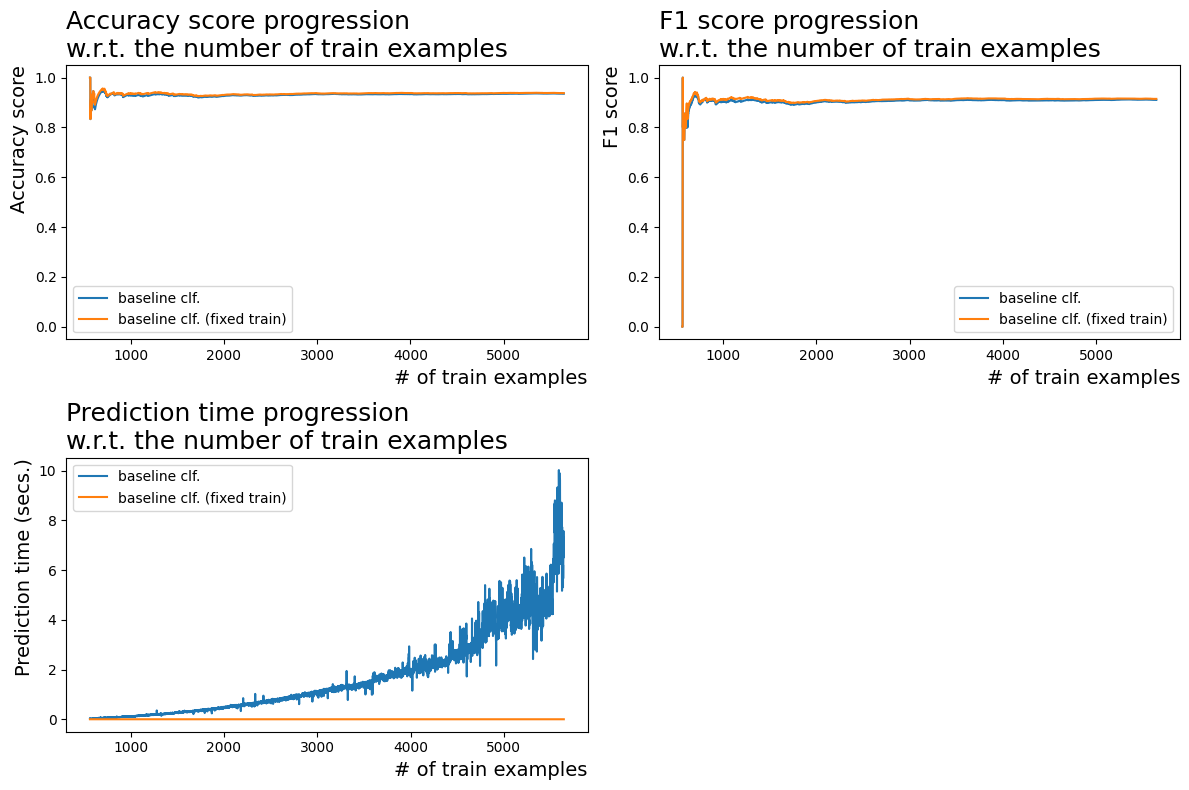

In [59]:
import matplotlib.pyplot as plt

score_vals = {}
for score_f in [accuracy_score, f1_score]:
    score_name = score_f.__name__
    preds = y_preds
    score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]
    
    score_name = score_f.__name__ + '_fixedtrain'
    preds = y_preds_fixedtrain
    score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]

plt.rcParams['figure.facecolor'] = (1,1,1,1)

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# First two plots are for prediction quality comparison
for ax, t in zip(axs[0],['accuracy_score', 'f1_score']):
    ax.set_ylim(0-0.05, 1+0.05)
    ax.plot(range(n_train+1, len(X)), score_vals[t], label='baseline clf.')
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_fixedtrain'], label='baseline clf. (fixed train)')
    
# The third plot is for prediction speed comparison
axs[1,0].plot(range(n_train, len(X)), t_preds, label='baseline clf.')
axs[1,0].plot(range(n_train, len(X)), t_preds_fixedtrain, label='baseline clf. (fixed train)')

# Add labels and titles to the plots
for (ax, t_verb, dim) in zip(axs.flatten(), ['Accuracy score', 'F1 score', 'Prediction time'], ['','','(secs.)']):
    ax.set_title('\n'.join([f"{t_verb} progression", "w.r.t. the number of train examples"]), loc='left', size=18)
    ax.set_xlabel('# of train examples', loc='right', size=14)
    ax.set_ylabel(f"{t_verb} {dim}".strip(), loc='top', size=14)
    ax.legend()
    
# Drop the predefined fourth plot since we do not use it
axs[1,1].set_axis_off()    

# Some postprocessing of plots
plt.tight_layout()
plt.subplots_adjust()

plt.savefig('Classifier_comparison_initial_algo_mushrooms.png')
plt.show()

<a name="step2.2"> </a>

### Algorithm with proposed improvements

In [61]:
%%time
gen = lpipe_improved.predict_array(X, y, n_train, use_tqdm=True)
y_preds, t_preds = lpipe.apply_stopwatch(gen)

Predicting step by step: 100%|██████████| 5644/5644 [29:06<00:00,  2.91it/s]

CPU times: total: 20min 52s
Wall time: 29min 6s


In [64]:
%%time
gen = list(lpipe_improved.predict_array(X, y, n_train, use_tqdm=True, update_train=False))
y_preds_fixedtrain, t_preds_fixedtrain = lpipe.apply_stopwatch(gen)

Predicting step by step: 100%|██████████| 5644/5644 [00:43<00:00, 116.86it/s]

CPU times: total: 32.5 s
Wall time: 43.5 s


In [65]:
score_vals = {}
for score_f in [accuracy_score, f1_score]:
    score_name = score_f.__name__
    preds = y_preds
    score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]
    
    score_name = score_f.__name__ + '_fixedtrain'
    preds = y_preds_fixedtrain
    score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]

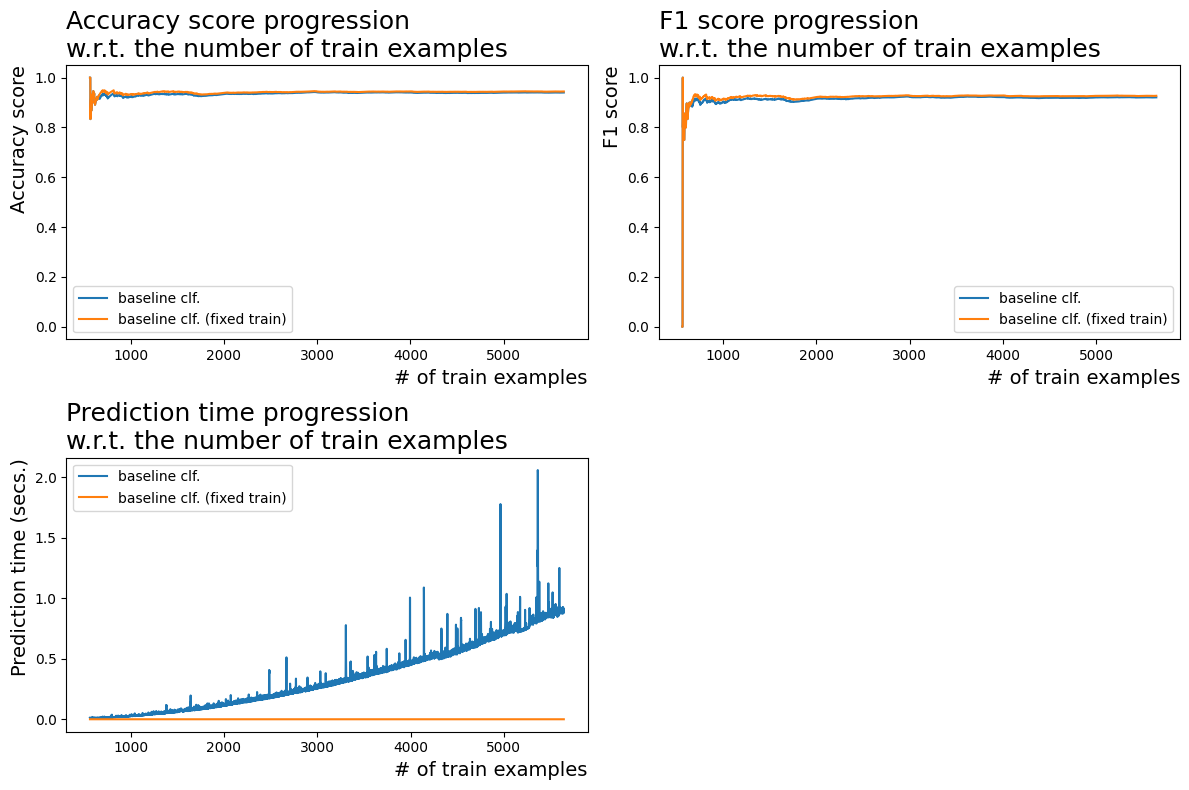

In [66]:
plt.rcParams['figure.facecolor'] = (1,1,1,1)

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# First two plots are for prediction quality comparison
for ax, t in zip(axs[0],['accuracy_score', 'f1_score']):
    ax.set_ylim(0-0.05, 1+0.05)
    ax.plot(range(n_train+1, len(X)), score_vals[t], label='baseline clf.')
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_fixedtrain'], label='baseline clf. (fixed train)')
    
# The third plot is for prediction speed comparison
axs[1,0].plot(range(n_train, len(X)), t_preds, label='baseline clf.')
axs[1,0].plot(range(n_train, len(X)), t_preds_fixedtrain, label='baseline clf. (fixed train)')

# Add labels and titles to the plots
for (ax, t_verb, dim) in zip(axs.flatten(), ['Accuracy score', 'F1 score', 'Prediction time'], ['','','(secs.)']):
    ax.set_title('\n'.join([f"{t_verb} progression", "w.r.t. the number of train examples"]), loc='left', size=18)
    ax.set_xlabel('# of train examples', loc='right', size=14)
    ax.set_ylabel(f"{t_verb} {dim}".strip(), loc='top', size=14)
    ax.legend()
    
# Drop the predefined fourth plot since we do not use it
axs[1,1].set_axis_off()    

# Some postprocessing of plots
plt.tight_layout()
plt.subplots_adjust()

plt.savefig('Classifier_comparison_improved_algo_mushrooms.png')
plt.show()

<a name="step3"> </a>

## Applying to the Congressional Voting Records Dataset

[To the ToC](#content)

In [69]:
data = pd.read_csv(CONGRESS_VOTING_DATA_PATH, names=CONGRESS_VOTING_COLUMNS_NAMES, index_col=None)
print(data.shape)
data.sample(3)

(435, 17)


,target,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
20,democrat,y,y,y,n,n,?,y,y,n,n,y,n,n,n,y,y
155,republican,y,y,n,y,y,y,n,?,n,n,y,y,y,y,n,n
102,democrat,y,n,y,n,y,y,y,n,?,n,y,n,y,y,y,?


In [70]:
data = data.replace("?", None).dropna()


In [71]:
data.loc[data['target'] == 'democrat', "target"] = False
data.loc[data['target'] == 'republican', "target"] = True

In [72]:
X = lpipe.binarize_X(data.drop("target", axis=1))
y = data["target"]

In [73]:
X_bin = [set(X.columns[x]) for idx, x in X.iterrows()]
X_bin[0]

{'adoption-of-the-budget-resolution: y',
 'aid-to-nicaraguan-contras: n',
 'anti-satellite-test-ban: n',
 'crime: y',
 'duty-free-exports: y',
 'education-spending: n',
 'el-salvador-aid: y',
 'export-administration-act-south-africa: y',
 'handicapped-infants: n',
 'immigration: n',
 'mx-missile: n',
 'physician-fee-freeze: n',
 'religious-groups-in-schools: y',
 'superfund-right-to-sue: y',
 'synfuels-corporation-cutback: n',
 'water-project-cost-sharing: y'}

In [74]:
X = X.sample(frac=1, random_state=42)  # Shuffle X
y = y[X.index]  # Order y to follow the order of rows from X

In [75]:
y = y.values.tolist()

In [76]:
n_train = int(len(X)*0.1)
n_test = len(X) - n_train
y_test = y[n_train:]
n_train, n_test

(23, 209)

<a name="step3.1"> </a>

### Initial algorithm

In [77]:
%%time
gen = lpipe.predict_array(X_bin, y, n_train, use_tqdm=True)
y_preds, t_preds = lpipe.apply_stopwatch(gen)

Predicting step by step: 100%|██████████| 232/232 [00:00<00:00, 511.46it/s] 

CPU times: total: 141 ms
Wall time: 416 ms


In [78]:
%%time
gen = list(lpipe.predict_array(X_bin, y, n_train, use_tqdm=True, update_train=False))
y_preds_fixedtrain, t_preds_fixedtrain = lpipe.apply_stopwatch(gen)

Predicting step by step: 100%|██████████| 232/232 [00:00<00:00, 16711.33it/s]

CPU times: total: 15.6 ms
Wall time: 14.5 ms


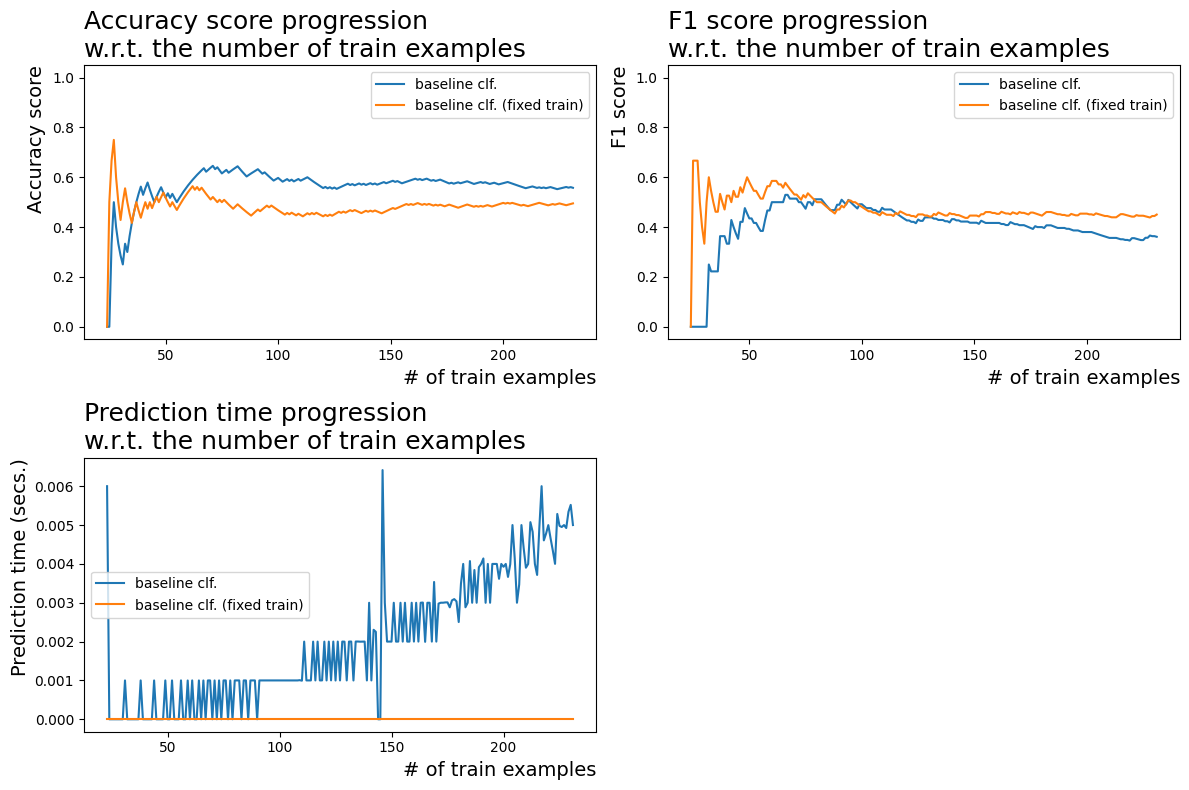

In [79]:
import matplotlib.pyplot as plt

score_vals = {}
for score_f in [accuracy_score, f1_score]:
    score_name = score_f.__name__
    preds = y_preds
    score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]
    
    score_name = score_f.__name__ + '_fixedtrain'
    preds = y_preds_fixedtrain
    score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]

plt.rcParams['figure.facecolor'] = (1,1,1,1)

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# First two plots are for prediction quality comparison
for ax, t in zip(axs[0],['accuracy_score', 'f1_score']):
    ax.set_ylim(0-0.05, 1+0.05)
    ax.plot(range(n_train+1, len(X)), score_vals[t], label='baseline clf.')
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_fixedtrain'], label='baseline clf. (fixed train)')
    
# The third plot is for prediction speed comparison
axs[1,0].plot(range(n_train, len(X)), t_preds, label='baseline clf.')
axs[1,0].plot(range(n_train, len(X)), t_preds_fixedtrain, label='baseline clf. (fixed train)')

# Add labels and titles to the plots
for (ax, t_verb, dim) in zip(axs.flatten(), ['Accuracy score', 'F1 score', 'Prediction time'], ['','','(secs.)']):
    ax.set_title('\n'.join([f"{t_verb} progression", "w.r.t. the number of train examples"]), loc='left', size=18)
    ax.set_xlabel('# of train examples', loc='right', size=14)
    ax.set_ylabel(f"{t_verb} {dim}".strip(), loc='top', size=14)
    ax.legend()
    
# Drop the predefined fourth plot since we do not use it
axs[1,1].set_axis_off()    

# Some postprocessing of plots
plt.tight_layout()
plt.subplots_adjust()

plt.savefig('Classifier_comparison_initial_algo_congress.png')
plt.show()

<a name = "step3.2"> </a>

### Algorithm with proposed improvements

In [82]:
%%time
gen = lpipe_improved.predict_array(X, y, n_train, use_tqdm=True)
y_preds, t_preds = lpipe.apply_stopwatch(gen)

Predicting step by step: 100%|██████████| 232/232 [00:00<00:00, 1895.52it/s]

CPU times: total: 78.1 ms
Wall time: 111 ms


In [83]:
%%time
gen = list(lpipe_improved.predict_array(X, y, n_train, use_tqdm=True, update_train=False))
y_preds_fixedtrain, t_preds_fixedtrain = lpipe.apply_stopwatch(gen)

Predicting step by step: 100%|██████████| 232/232 [00:00<00:00, 3759.48it/s]

CPU times: total: 15.6 ms
Wall time: 58.6 ms


In [60]:
score_vals = {}
for score_f in [accuracy_score, f1_score]:
    score_name = score_f.__name__
    preds = y_preds
    score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]
    
    score_name = score_f.__name__ + '_fixedtrain'
    preds = y_preds_fixedtrain
    score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]

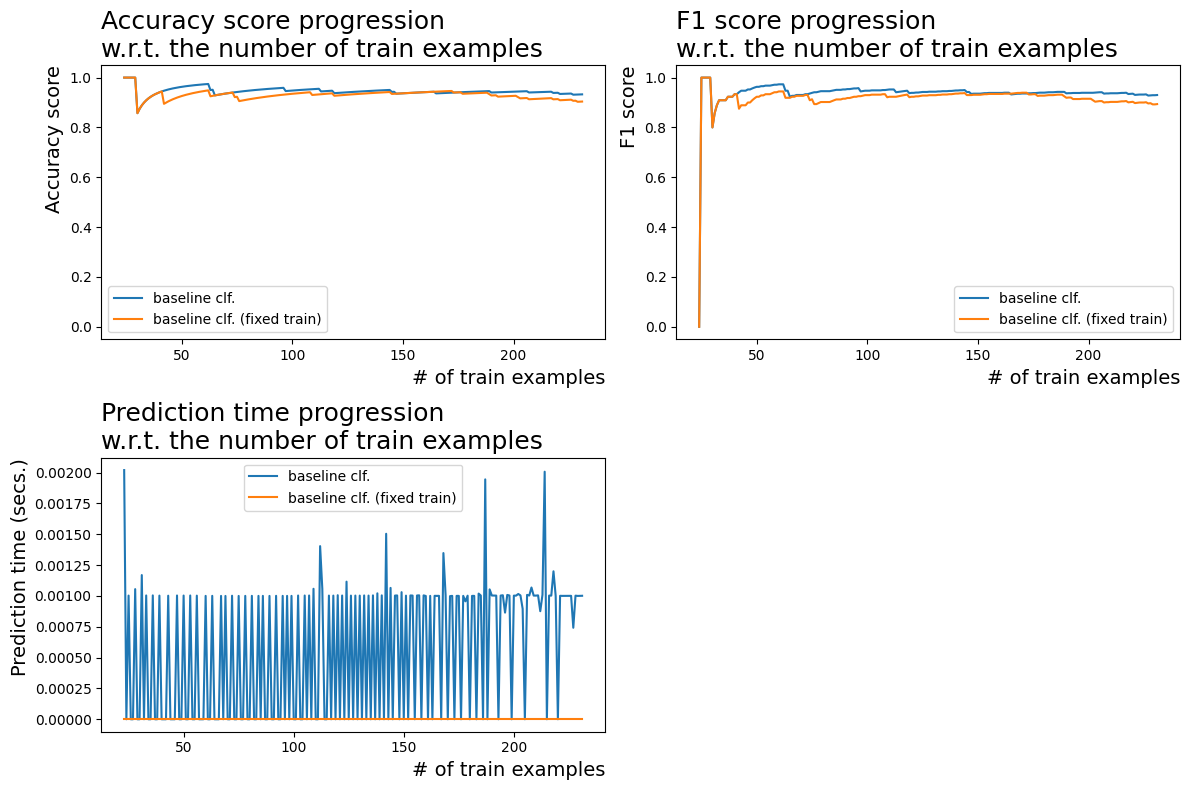

In [61]:
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = (1,1,1,1)  # Replace default "transparent" background of the figure with the "white" one


fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# First two plots are for prediction quality comparison
for ax, t in zip(axs[0],['accuracy_score', 'f1_score']):
    ax.set_ylim(0-0.05, 1+0.05)
    ax.plot(range(n_train+1, len(X)), score_vals[t], label='baseline clf.')
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_fixedtrain'], label='baseline clf. (fixed train)')
    
# The third plot is for prediction speed comparison
axs[1,0].plot(range(n_train, len(X)), t_preds, label='baseline clf.')
axs[1,0].plot(range(n_train, len(X)), t_preds_fixedtrain, label='baseline clf. (fixed train)')

# Add labels and titles to the plots
for (ax, t_verb, dim) in zip(axs.flatten(), ['Accuracy score', 'F1 score', 'Prediction time'], ['','','(secs.)']):
    ax.set_title('\n'.join([f"{t_verb} progression", "w.r.t. the number of train examples"]), loc='left', size=18)
    ax.set_xlabel('# of train examples', loc='right', size=14)
    ax.set_ylabel(f"{t_verb} {dim}".strip(), loc='top', size=14)
    ax.legend()
    
# Drop the predefined fourth plot since we do not use it
axs[1,1].set_axis_off()    

# Some postprocessing of plots
plt.tight_layout()
plt.subplots_adjust()

plt.savefig('Classifier_comparison_improved_algo_congress.png')
plt.show()

<a name="step4"> </a>

## Comparison with other rule-based models

[To the ToC](#content)

In [4]:
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRFClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
import catboost
import time

In [45]:
data = pd.read_csv(CARS_DATA_PATH, names=CARS_COLUMNS_NAMES, index_col=None)
data = data[(data['target'] != 'good') & (data['target'] != 'vgood')]

In [46]:
data.loc[data['target'] == 'unacc', "target"] = False
data.loc[data['target'] == 'acc', "target"] = True

In [47]:
X = data.drop(columns=["target"])
y = data["target"]

In [8]:
from catboost import Pool, cv
train_pool = Pool(data=X, label=y, cat_features=X.columns.to_list(), has_header=True)

In [9]:
def print_cv_summary(cv_data):
    cv_data.head(10)

    best_value = cv_data['test-Logloss-mean'].min()
    best_iter = cv_data['test-Logloss-mean'].values.argmin()

    print('Best validation Logloss score : {:.4f}±{:.4f} on step {}'.format(
        best_value,
        cv_data['test-Logloss-std'][best_iter],
        best_iter)
    )


In [131]:
params_f1 = {
    'loss_function': 'Logloss',
    'iterations': 100,
    'custom_loss': 'AUC',
    'eval_metric': 'F1',
    'learning_rate': 0.5,
}
params_accuracy = {
    'loss_function': 'Logloss',
    'iterations': 100,
    'custom_loss': 'AUC',
    'eval_metric': 'BalancedAccuracy',
    'learning_rate': 0.5,
}

def results_catboost_cv(train_pool: catboost.core.Pool):
    start_time = time.time()
    cv_data = cv(
        params = params_f1,
        pool = train_pool,
        fold_count=5,
        shuffle=True,
        partition_random_seed=0,
        plot=True,
        stratified=False,
        verbose=False
    )
    print("Wall time", time.time() - start_time)
    print_cv_summary(cv_data)
    print("Average f1_score through cross-validation: %.3f"%cv_data['test-F1-mean'].mean())
    cv_data = cv(
        params = params_accuracy,
        pool = train_pool,
        fold_count=5,
        shuffle=True,
        partition_random_seed=0,
        plot=True,
        stratified=False,
        verbose=False
    )
    
    print("Average accuracy through cross-validation: %.3f"%cv_data['test-BalancedAccuracy-mean'].mean())

In [132]:
results_catboost_cv(train_pool=train_pool)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.9565217391
bestIteration = 6

Training on fold [1/5]

bestTest = 0.9367088608
bestIteration = 20

Training on fold [2/5]

bestTest = 0.9638554217
bestIteration = 11

Training on fold [3/5]

bestTest = 0.9375
bestIteration = 23

Training on fold [4/5]

bestTest = 0.9411764706
bestIteration = 9

Wall time 16.089555501937866
Best validation Logloss score : 0.0857±0.0154 on step 40
Average f1_score through cross-validation: 0.922


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.9855371901
bestIteration = 6

Training on fold [1/5]

bestTest = 0.9660566706
bestIteration = 20

Training on fold [2/5]

bestTest = 0.9874476987
bestIteration = 11

Training on fold [3/5]

bestTest = 0.9704840614
bestIteration = 23

Training on fold [4/5]

bestTest = 0.9768241543
bestIteration = 9

Average accuracy through cross-validation: 0.958


In [48]:
X_dummy = pd.get_dummies(X)

In [49]:
from sklearn.model_selection import  GridSearchCV, cross_validate

def results_cv(clf, X_dummy, y):
    grid = GridSearchCV(clf(), 
            {'max_depth': range(3,20)}, cv=5)
            
    grid.fit(X_dummy.values, y.values.astype(int))
    start_time = time.time()
    res_dt = cross_validate(clf(max_depth=grid.best_params_['max_depth']), 
        X_dummy.values, y.values.astype(int), cv=5, scoring=["f1_micro", "balanced_accuracy"])

    print("Wall time: ", time.time() - start_time)

    print("Average f1_score through cross-validation: %.3f"%res_dt['test_f1_micro'].mean())
    
    print("Average accuracy through cross-validation: %.3f"%res_dt['test_balanced_accuracy'].mean())



In [50]:
results_cv(DecisionTreeClassifier, X_dummy, y)

Wall time:  0.009285926818847656
Average f1_score through cross-validation: 0.838
Average accuracy through cross-validation: 0.816


In [51]:
results_cv(RandomForestClassifier, X_dummy, y)

Wall time:  0.4761803150177002
Average f1_score through cross-validation: 0.841
Average accuracy through cross-validation: 0.775


In [52]:
results_cv(XGBRFClassifier, X_dummy, y)

Wall time:  0.2122809886932373
Average f1_score through cross-validation: 0.844
Average accuracy through cross-validation: 0.796


In [53]:
results_cv(LGBMClassifier, X_dummy, y)

Wall time:  0.07541990280151367
Average f1_score through cross-validation: 0.865
Average accuracy through cross-validation: 0.813


In [58]:
data = pd.read_csv(MUSHROOM_DATA_PATH, names=MUSHROOM_COLUMNS_NAMES, index_col=None)
data = data.replace("?", None).dropna()
data.loc[data['target'] == 'e', "target"] = False
data.loc[data['target'] == 'p', "target"] = True

In [59]:
X = data.drop(columns=["target"])
y = data["target"]

In [137]:
train_pool = Pool(data=X, label=y, cat_features=X.columns.to_list(), has_header=True)

In [138]:
results_catboost_cv(train_pool=train_pool)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 1
bestIteration = 3

Training on fold [1/5]

bestTest = 1
bestIteration = 4

Training on fold [2/5]

bestTest = 1
bestIteration = 6

Training on fold [3/5]

bestTest = 1
bestIteration = 3

Training on fold [4/5]

bestTest = 1
bestIteration = 3

Wall time 16.959166288375854
Best validation Logloss score : 0.0004±0.0001 on step 99
Average f1_score through cross-validation: 1.000


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 1
bestIteration = 3

Training on fold [1/5]

bestTest = 1
bestIteration = 4

Training on fold [2/5]

bestTest = 1
bestIteration = 6

Training on fold [3/5]

bestTest = 1
bestIteration = 3

Training on fold [4/5]

bestTest = 1
bestIteration = 3

Average accuracy through cross-validation: 1.000


In [60]:
X_dummy = pd.get_dummies(X)

In [62]:
for clf in [DecisionTreeClassifier, RandomForestClassifier, XGBRFClassifier, LGBMClassifier]:
    display(Markdown(f'<h1>{clf.__name__}'))
    results_cv(clf, X_dummy, y)

<h1>DecisionTreeClassifier

Wall time:  0.04495525360107422
Average f1_score through cross-validation: 0.937
Average accuracy through cross-validation: 0.926


<h1>RandomForestClassifier

Wall time:  0.8540754318237305
Average f1_score through cross-validation: 0.930
Average accuracy through cross-validation: 0.917


<h1>XGBRFClassifier

Wall time:  0.6731753349304199
Average f1_score through cross-validation: 0.944
Average accuracy through cross-validation: 0.932


<h1>LGBMClassifier

Wall time:  0.15664982795715332
Average f1_score through cross-validation: 0.941
Average accuracy through cross-validation: 0.927


In [66]:
data = pd.read_csv(CONGRESS_VOTING_DATA_PATH, names=CONGRESS_VOTING_COLUMNS_NAMES, index_col=None)
data = data.replace("?", None).dropna()
data.loc[data['target'] == 'democrat', "target"] = False
data.loc[data['target'] == 'republican', "target"] = True
X = data.drop(columns=["target"])
y = data["target"]
train_pool = Pool(data=X, label=y, cat_features=X.columns.to_list(), has_header=True)

In [140]:
results_catboost_cv(train_pool=train_pool)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.9811320755
bestIteration = 0

Training on fold [1/5]

bestTest = 0.9545454545
bestIteration = 0

Training on fold [2/5]

bestTest = 0.9545454545
bestIteration = 0

Training on fold [3/5]

bestTest = 0.9268292683
bestIteration = 0

Training on fold [4/5]

bestTest = 1
bestIteration = 2

Wall time 1.1012818813323975
Best validation Logloss score : 0.1239±0.0574 on step 5
Average f1_score through cross-validation: 0.949


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.9761904762
bestIteration = 0

Training on fold [1/5]

bestTest = 0.9615384615
bestIteration = 0

Training on fold [2/5]

bestTest = 0.9564393939
bestIteration = 0

Training on fold [3/5]

bestTest = 0.9365384615
bestIteration = 0

Training on fold [4/5]

bestTest = 1
bestIteration = 2

Average accuracy through cross-validation: 0.952


In [67]:
X_dummy = pd.get_dummies(X)

In [68]:
for clf in [DecisionTreeClassifier, RandomForestClassifier, XGBRFClassifier, LGBMClassifier]:
    display(Markdown(f'<h1>{clf.__name__}'))
    results_cv(clf, X_dummy, y)

<h1>DecisionTreeClassifier

Wall time:  0.007070064544677734
Average f1_score through cross-validation: 0.965
Average accuracy through cross-validation: 0.966


<h1>RandomForestClassifier

Wall time:  0.3620929718017578
Average f1_score through cross-validation: 0.961
Average accuracy through cross-validation: 0.961


<h1>XGBRFClassifier

Wall time:  0.08620095252990723
Average f1_score through cross-validation: 0.970
Average accuracy through cross-validation: 0.971


<h1>LGBMClassifier

Wall time:  0.0653376579284668
Average f1_score through cross-validation: 0.957
Average accuracy through cross-validation: 0.957


<a name="step5"> </a>

## Inferences

[To the ToC](#content)